# Adaptive time stepping for a multitraces formulation problem coupled with ordinary differential equations

Code considerations:
- We use solve_ivp from SciPy to solve the resulting system of ODE:s, in order to take advantage of adaptive time stepping.

Import of the numpy library:

In [1]:
import numpy as np

Here we solve a example associated with the electropermeabilization problem. See article [Cell Electropermeabilization Modeling via Multiple Traces Formulation and Time Semi-Implicit Coupling](https://arxiv.org/abs/2403.19371) where the model and formulation are described. In this notebook we present one of the simulations of Section 4.3.2 of the same article.

## One sphere

We assume that the center of the sphere is in the origin.

### Parameters set up.

First, we set up the parameters of the problem:

#### Geometry and physical parameters

Radius of the sphere. It has to be a float number:

In [2]:
radius = 10.

The variable `sigmas` is a numpy array with the medium conductivities in the order $\sigma_0$, $\sigma_1$. The numbers have to be floats:

In [3]:
sigma_e = 15. # extracellular conductivity, [microS / micro m]
sigma_i =  1.5  # intracellular conductivity, [microS / micro m]
sigmas = np.asarray([sigma_e, sigma_i])

Capacitance of the membrane (needs to be a float):

In [4]:
c_m = 1.
# c_m = 9.5*10**(-3)  # capacitance [p F / (micro m) ** 2] (This unit is for the Kavian et al. problem)

#### Discretization parameters

Maximum degree of the spherical harmonics to be used for discretize ($L$). It has to be an integer:

In [5]:
big_l = 17

Maximum degree of the spherical harmonics to be used for quadratures ($L_c$). It has to be an integer:

In [6]:
big_l_c = 60

Parameters for the time scheme used:

In [7]:
initial_time = 0.
final_time = 10.
number_steps = 2**13

#### Initial conditions

Set up of initial conditions, for this model we need two arrays of length `(big_l + 1)**2`. Each array has the coefficients of the spherical harmonic expansion of each initial condition.
In the following we give a couple of examples for building one of the arrays:

In [8]:
# Initial condition equal to zero
v_0_zero = np.zeros(((big_l+1)**2))
# Intial condition equal to a cte value
cte = 4.
v_0_cte_value = np.zeros(((big_l+1)**2))
v_0_cte_value[0] = cte * 2* np.sqrt(np.pi)

In this example we use initial conditions equal to zero. We need to set up both arrays in one:

In [9]:
initial_conditions = np.zeros((2*(big_l+1)**2,))

#### Set up of the external excitation

Set up the contributions to the right hand side made by $\phi_e$. For this, we set up a function only dependent on time, to account for changes in time. In the module `biosspheres.formulations.mtf.timecouplings.righthands` there are implementations on how to do this. We show some of the predetermined, and how to make a new one:

Pre-defined:

In [10]:
# Import of the module where pre-defined right hand sides are.
import biosspheres.formulations.mtf.timecouplings.righthands as righthands
# phi_e cte in time and space
cte=5.
phi_cte_space_time = righthands.phi_part_of_b_cte_space_and_time(
	big_l, n=1, radii=np.asarray([radius]), cte=cte
)
# phi_e point source in space, cte in time
phi_point_source_space_cte_time = righthands.phi_part_of_b_point_source_space_and_cte_time(
  big_l, n=1, radii=np.asarray([radius]), center_positions=[np.zeros((3))], p0 = 25.*np.ones((3)),
  sigma_e = sigmas[0], pii = np.asarray([sigmas[1]/sigmas[0]]), amplitude = 1.
)
# phi_e = cte * z_coordinate
phi_point_source_linear = righthands.phi_part_of_b_linear_space_z_cte_time(
  big_l, n=1, radii=np.asarray([radius]), center_positions=[np.zeros((3))],cte=cte, pii = np.asarray([sigmas[1]/sigmas[0]]))

Custom made:

In [11]:
# Space part, cte * z_coordinate
import biosspheres.formulations.mtf.mtf as mtf
import biosspheres.formulations.mtf.righthands as mtfrighthand

# Parameters for the function
n=1
radii=np.asarray([radius])
cte = 5.
ps =[np.zeros((3))]
pii = np.asarray([sigmas[1]/sigmas[0]])
x_dia, x_dia_inv = mtf.x_diagonal_with_its_inv(
        n, big_l, radii, pii, azimuthal=False
    )
# Pre-defined space part
space_phi = mtfrighthand.b_vector_n_spheres_mtf_linear_function_z(
    big_l, n, ps, cte, radii, x_dia)

# Time part, custom made
def time_function(time):
  if time >= 5. or time < 0:
    return 0.
  else:
    return 1.


custom_phi = righthands.phi_part_of_b_separable_in_space_time(space_phi, time_function)

b_phi_part_time_function = custom_phi

In [12]:
q=custom_phi(0)
print(q.shape, 4*(big_l+1)**2)
import biosspheres.formulations.mtf.timecouplings.linearoperators as tclo
iden_2n_n = 2 * tclo.mtf_coupling_iden_parts_sparse_array(
        big_l, 1, np.asarray([radius])
    )
print(iden_2n_n.shape)
p=iden_2n_n @ np.ones(((big_l+1)**2,))
print(p.shape)
s=np.concatenate((-p,p),axis=0)
print(s.shape)

(1296,) 1296
(648, 324)
(648,)
(1296,)


#### Parameters for the coupled currents and ordinary differential equations:

For Kavian et al. dynamics:

In [13]:
s_l = 1.9*10**(-6)  # [micro S / (micro m) ** 2]
s_ir = 2.5*10**2  # [micro S / (micro m) ** 2]
tau_ep = 1.  # [micro s]
tau_res = 10.**3  # [micro s]
k_ep = 40.  # [V ** -1]
v_rev = 1.5  # [V]

### Set up of the coupled problem

Set up of the non linear current. Different models for the current can be used, there are models ready to use in the module `biosspheres.miscella.forcouplings.currents`. See the internals of the module for making custom made currents.

In [14]:
import biosspheres.miscella.forcouplings.currents as currents
import biosspheres.miscella.forcouplings.oderesolutions as oderesolutions
import ep_odesolver

Kavian et al. current and auxiliary odes:

In [15]:
i_current = currents.i_kavian_leguebe_ea_2014_1_sphere_2d(big_l, big_l_c, radius, s_l, s_ir)
aux_rhs_fun = ep_odesolver.get_odeZ_kavian_rhsfun(big_l, big_l_c, k_ep, v_rev, tau_ep, tau_res)

### Solving

First, we set up internal parameters used for requirements of numpy for threading:

In [16]:
import os
number = "7" # Maximum of threads
os.environ["OMP_NUM_THREADS"] = number
os.environ["OPENBLAS_NUM_THREADS"] = number
os.environ["MKL_NUM_THREADS"] = number
os.environ["VECLIB_MAXIMUM_THREADS"] = number
os.environ["NUMEXPR_NUM_THREADS"] = number

We implemented a direct solver (LU decomposition) that takes as parameters what we previously defined, including the current and the coupled ODE system. The complete list can be seen in the following:

In [17]:
import time
startT = time.time()

solution = ep_odesolver.ep_solveodes_one_sphere(
    big_l,
    radius,
    sigmas,
    c_m,
    initial_time,
    final_time,
    initial_conditions,
    b_phi_part_time_function,
    i_current,
    aux_rhs_fun,
)

endT = time.time()
print(f'Solved problem in {(endT-startT)} s')

Solved problem in 6.843523740768433 s


In [31]:
solution.y.shape

(648, 132)

### Saving the results

The following saves all solutions, i.e. traces, transmembrane potential, and recovery variables, in numpy format. We have commented the line for the saving.

In [20]:
filename="example.npy"
directory=""
# np.save(directory+filename, solutions)

To load the solutions:

In [21]:
# solutions = np.load(directory+filename)

To save in `txt` format:

In [22]:
filename="example.txt"
directory=""
# np.savetxt(directory+filename, solutions)

To load the solutions:

In [23]:
# solutions = np.loadtxt(directory+filename)

### Plotting the results

For plotting the evolution of time of the solutions evaluated in the north pole of the sphere:

Text(0.5, 1.0, 'v')

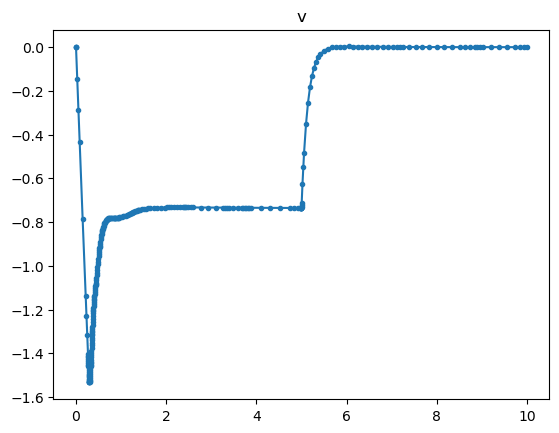

In [18]:
import matplotlib.pyplot as plt
# Auxiliary arrays for plotting
import biosspheres.utils.auxindexes as auxindexes
num = (big_l + 1)**2
eles, l_square_plus_l, el_square_plus_el_divided_by_two = (
        auxindexes.eles_combination(big_l)
    )
little_partial_spherical = np.sqrt((2 * eles + 1))
plt.figure()
plt.plot(
	solution.t,
	np.sum(
        solution.y[0 + l_square_plus_l[0 : big_l + 1], :].T
        * little_partial_spherical[0 : big_l + 1],
		axis=1,
	)
	/ (2.0 * np.sqrt(np.pi)),
	label="Numerical solution",
	marker=".",
)
plt.title("v")

Text(0.5, 1.0, 'Additional variable')

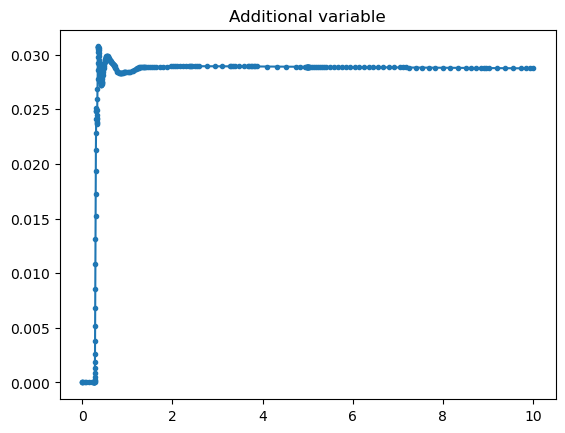

In [19]:
plt.figure()
little_partial_spherical = np.sqrt((2 * eles + 1))
plt.plot(
	solution.t,
	np.sum(
		solution.y[(num + l_square_plus_l[0 : big_l + 1]),:].T
		* little_partial_spherical[0 : big_l + 1],
		axis=1,
	)
	/ (2.0 * np.sqrt(np.pi)),
	label="Numerical solution",
	marker=".",
)
plt.title("Additional variable")

For plotting the transmembrane potential on the surface of the sphere at a given time:

In [20]:
# Auxiliary arrays
import biosspheres.quadratures.sphere as quadratures
(
	quantity_theta_points,
	quantity_phi_points,
	weights,
	pre_vector,
	spherical_harmonics,
) = quadratures.gauss_legendre_trapezoidal_real_sh_mapping_2d(
	big_l, big_l_c
)

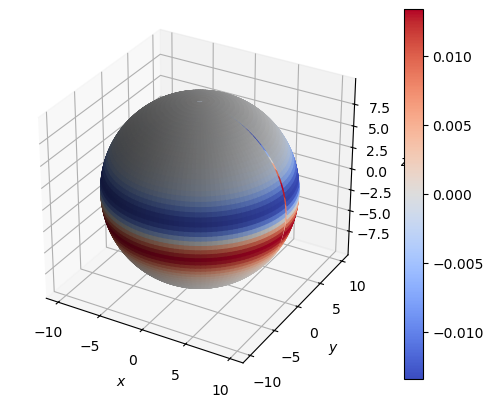

In [24]:
time_index = np.size(solution.t)-10  # time index of the simulation 
vector = pre_vector * radius
surface_v = np.zeros((quantity_theta_points, quantity_phi_points))
surface_v[:, :] = np.sum(
	solution.y[0:num, time_index, np.newaxis, np.newaxis]
	* spherical_harmonics, axis=0)
surface_v_max = np.max(np.abs(surface_v))
surface_v = (surface_v + surface_v_max) / (2. * surface_v_max)

from matplotlib import cm, colors
fig = plt.figure()
ax_1 = fig.add_subplot(111, projection='3d')
ax_1.plot_surface(
	vector[0, :, :],
	vector[1, :, :],
	vector[2, :, :],
	rstride=1, cstride=1, 
	facecolors=cm.coolwarm(surface_v[:, :]))
ax_1.set_xlabel('$x$')
ax_1.set_ylabel('$y$')
ax_1.set_zlabel('$z$')
ax_1.set_aspect('equal')
fig.colorbar(cm.ScalarMappable(
    norm=colors.CenteredNorm(halfrange=surface_v_max), cmap=cm.coolwarm),
    ax=ax_1)

That can be made a video too.

For plotting a plane cut without $\phi_e$:

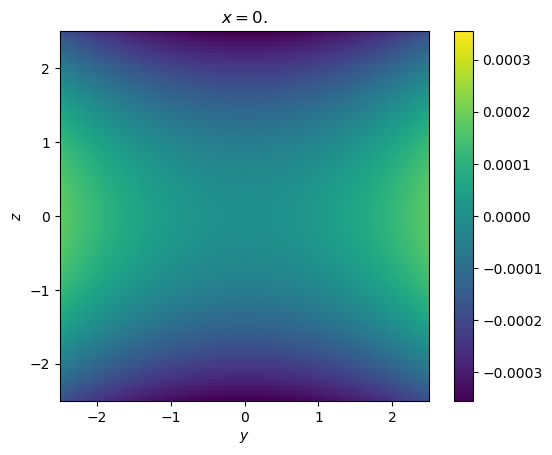

In [24]:
import biosspheres.laplace.drawing as draw
from matplotlib import cm, colors
cut = 1
# Size of the window to be plotted
horizontal = 5.
vertical = 5.
# For the resolution of the plot
inter_horizontal = 100
inter_vertical = 100
# For plotting without the external function we make the following function
def zero(x: np.ndarray) -> float:
    return 0.

x1, y1, data = draw.draw_cut_representation_formula_one_sphere_azimuthal_symmetry(
    cut, np.zeros((3)), horizontal, vertical, inter_horizontal, inter_vertical, solutions[time_index, 0 : 4 * num], radius, big_l, zero)
plt.figure()
plt.imshow(data, origin='lower',
           extent=[-horizontal / 2, horizontal / 2,
                   -vertical / 2, vertical / 2],
           norm=colors.CenteredNorm()
           )
plt.xlabel('$y$')
plt.ylabel('$z$')
plt.title('$x = 0.$')
plt.colorbar()

In [20]:
vt=np.sum(
        solution.y[0 + l_square_plus_l[0 : big_l + 1], :].T
        * little_partial_spherical[0 : big_l + 1],
		axis=1,
	) / (2.0 * np.sqrt(np.pi))
Zt = np.sum(
        solution.y[num + l_square_plus_l[0 : big_l + 1], :].T
        * little_partial_spherical[0 : big_l + 1],
		axis=1,
	) / (2.0 * np.sqrt(np.pi))

np.save('odesolve_sol.npy',(solution.t,vt,Zt))